In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

from optimize_funcs import *

# OPTIMIZE

In [2]:
label = 'd_we'
b, b_true = setup_bundle_wrong(label)

In [3]:
ecc = 0.2753709681902242
per0 = 1.4824337277607507
esinw = ecc*np.sin(per0)
ecosw = ecc*np.cos(per0)

100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


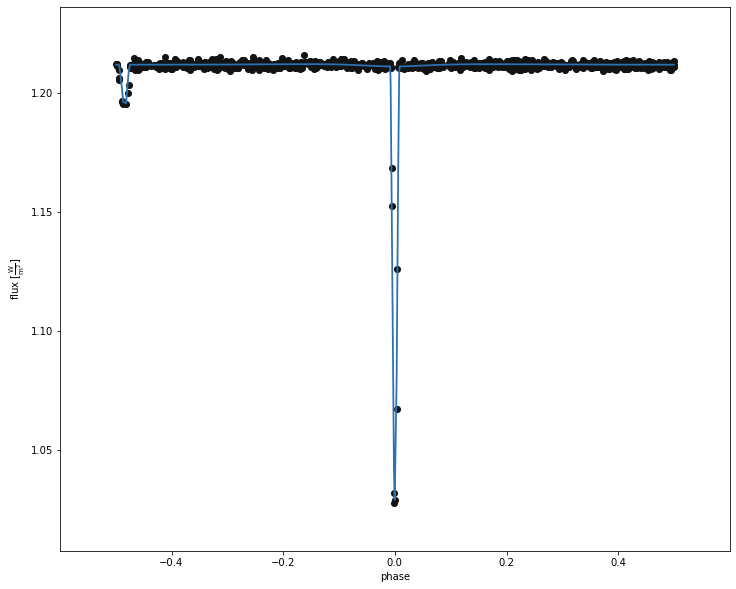

In [4]:
b = update_vals(b, 
                ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'], 
                [87., 0.9, 0.07885319, 0.43, esinw, ecosw],
               'ellcbnd')

In [5]:
b.save('data/%s_manual_wrong.bundle' % label)

'data/d_we_manual_wrong.bundle'

### optimize full

In [7]:
label = 'we_nm_wrong'
#b = phoebe.load('data/d_we_manual_wrong.bundle')

In [8]:
#b=optimize_params(b, ['incl@binary', 'teffratio', 'requivratio', 'requivsumfrac', 'esinw', 'ecosw'], 'full', 'ellcbnd', optimizer='nm',  plot=True)

In [9]:
#b.save('data/%s_full.bundle' % label)

# MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe

from optimize_funcs import *

100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


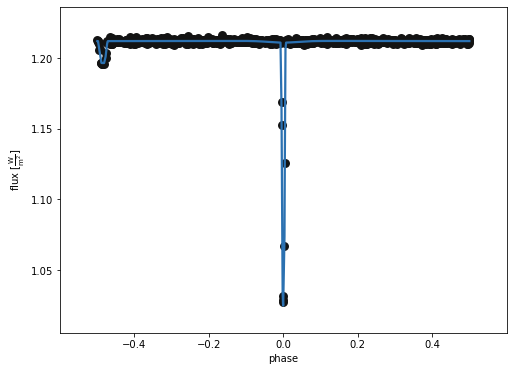

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [2]:
b = phoebe.load('data/we_nm_wrong_full.bundle')
b.run_compute(compute='ellcbnd', model='latest')
b.plot(['dataset', 'latest'], x='phase',show=True)

In [3]:
params0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'])
priors0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1]])

params_teff1_sma_q_p_t0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw', 
                                'teff@primary',
                                'sma@binary', 'q',
                                'period@binary', 't0_supconj'])
priors_teff1_sma_q_p_t0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1], 
                        [3500,20000],
                        [5,50], [0.1,10],
                        [np.nan,np.nan], [np.nan,np.nan]])

In [4]:
b=add_dist_solver_export(b,params0, priors0, 'we_wrong', '0')
b=add_dist_solver_export(b,params_teff1_sma_q_p_t0, priors_teff1_sma_q_p_t0, 'we_wrong', 'teff1_sma_q_p_t0')

In [5]:
b.save('data/we_nm_wrong_dists.bundle')

'data/we_nm_wrong_dists.bundle'

# RESULTS

In [1]:
def bundle_get_params_lc(filename, params_list, model_tag, true=False):
    b = phoebe.load('data/'+filename+'.bundle')
    if true:
        b.add_constraint('requivsumfrac')
        b.add_constraint('requivratio')
        b.add_constraint('teffratio')
        b.flip_constraint('teffratio', solve_for='teff@secondary')
        b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')
        b.flip_constraint('requivratio', solve_for='requiv@primary')
        b.flip_constraint('esinw', solve_for='ecc')
        b.flip_constraint('ecosw', solve_for='per0')
        b.flip_constraint('q', solve_for='mass@secondary')
        
    params = {}
    
    for param in params_list:
        params[param] = b.get_value(param)
    
    phases = b.to_phase(b['times@dataset@lc01'])
    fluxes = b['value@fluxes@%s@lc01' % model_tag]
    s=np.argsort(phases)
    
    lc = np.array([phases[s], fluxes[s]]).T
    if true:
        chi2 = np.nan
    else:
        residuals = b.calculate_residuals(model=model_tag)
        sigmas = b.get_value('sigmas', dataset='lc01')
        chi2 = np.sum((residuals.value**2 / sigmas))

    return {'solution': params, 'lc': lc, 'chi2': chi2}

def compute_y(solution, true, param):
    return 100*np.abs((solution['solution'][param]-true['solution'][param])/(true['solution'][param]))


def plot_solution(ax, title, labels, params, true, opt_right, opt_wrong, ylabel=False):
    
    s=50
    
    xs = np.arange(1, len(labels)+1, 1).astype(int)
    scatter_dict = {'x': [], 'y': [], 'fc': [], 'ec': [], 's': [], }

    for i,x in enumerate(xs):
        scatter_dict['x'] += [x, x, x, x, x, x]
        scatter_dict['fc'] += [cs['black'], cs['red']]
        scatter_dict['ec'] += [cs['black'], cs['none']]
        scatter_dict['y'] += [compute_y(opt_right, true, params[i]),
                              compute_y(opt_wrong, true, params[i])]                     
        scatter_dict['s'] += [s*opt_right['chi2'],
                              s*opt_wrong['chi2']]
                              
        
        ax.scatter(scatter_dict['x'][0], scatter_dict['y'][0], marker='o', 
               s=scatter_dict['s'][0], 
               facecolors=scatter_dict['fc'][0],
               edgecolors=scatter_dict['ec'][0], label='$T_1$, $a$ true for system')
        ax.scatter(scatter_dict['x'][1], scatter_dict['y'][1], marker='o', 
               s=scatter_dict['s'][1], 
               facecolors=scatter_dict['fc'][1],
               edgecolors=scatter_dict['ec'][1], label='$T_1$, $a$ at PHOEBE defaults')
            

    ax.margins(0.2)
    ax.grid(linestyle=':', linewidth='0.5', color='#131313', alpha=0.75)
    for gl in ax.get_xgridlines():
        gl.set_color(cs['black'])
        gl.set_linewidth(1)
        gl.set_linestyle('--')
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.set_title(title) 
    return ax, scatter_dict


def plot_lc(ax, true, opt_right, opt_wrong):
    ax.plot(true['lc'][:,0], true['lc'][:,1], '.', ms=10, alpha=0.5, c='gray')
    ax.plot(opt_right['lc'][:,0], opt_right['lc'][:,1], '-', lw=2, alpha=0.75, c=cs['black'])
    ax.plot(opt_wrong['lc'][:,0], opt_wrong['lc'][:,1], '--', c=cs['red'])
    ax.set_xlabel(r'Orbital phase')
    ax.set_ylabel(r'Flux $[W/m^2]$')

In [ ]:
we_right = bundle_get_params_lc('we_nm_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
we_right = bundle_get_params_lc('we_nm_wrong_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
